In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline # Useful for combining vectorizer and model
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # To save the trained model

print("Modeling libraries imported successfully.")

Modeling libraries imported successfully.


# Modeling Phase: Step 1 - Load Cleaned and Enriched Data 

Before we can build any machine learning models, we need to load the dataset that we have cleaned and prepared during the Exploratory Data Analysis (EDA) phase. This dataset should contain the essential information we need for modeling, including the text of the reviews and the target variable we want to predict. 

In this project, our goal for modeling is to predict the sentiment of a review. During EDA, we used the VADER sentiment analysis tool to calculate a sentiment score (VADER_Score) and classify each review into categories (VADER_Sentiment: Positive, Negative, Neutral). This VADER_Sentiment column will serve as our target variable (y) for the classification model. 

This cell performs the following actions: 

    Load Data: It attempts to read the CSV file (cleaned_reviews_data.csv) that should have been saved at the end of the 02_eda_insights.ipynb notebook.
    Verify Data: It prints basic information about the loaded data (shape, first few rows, column info) to confirm it loaded correctly.
    Check for Target Variable: Crucially, it checks whether the VADER_Sentiment column is present in the loaded data. This column is essential for training our sentiment classification model.
    Provide Guidance: If the VADER_Sentiment column is missing, it provides helpful messages:
        It confirms the column is missing.
        It checks for the Rating column as a potential fallback to create a simple sentiment label.
        It provides example code on how to create a Simple_Sentiment label from the Rating if needed.
         
    Handle Errors: It includes error handling to provide clear messages if the file is not found or if any other unexpected error occurs during loading.
     

In [2]:
# Cell 2: Load Cleaned Data
# Assuming you saved it as 'cleaned_reviews_data.csv' in the previous phase
data_file = 'cleaned_reviews_data.csv' # <-- Make sure this filename is correct!

try:
    df = pd.read_csv(data_file)
    print(f"Data loaded successfully from '{data_file}'.")
    print(f"DataFrame shape: {df.shape}")
    print("\n--- First 5 Rows ---")
    print(df.head())
    print("\n--- DataFrame Info ---")
    print(df.info())

    # --- Check for VADER_Sentiment column ---
    print("\n--- Checking for Sentiment Columns ---")
    if 'VADER_Sentiment' in df.columns:
        print("'VADER_Sentiment' column found.")
        print("\n--- Sentiment Distribution (VADER) ---")
        print(df['VADER_Sentiment'].value_counts())
    else:
        print("Warning: 'VADER_Sentiment' column NOT found in the loaded data.")
        # Check if Rating column exists, as a potential fallback
        if 'Rating' in df.columns:
            print("'Rating' column found. You can derive a simple sentiment from it if needed.")
            print("Example distribution of Ratings:")
            print(df['Rating'].value_counts().sort_index())
            print("\nTo create a simple sentiment label, you can add a cell like this:")
            print("df['Simple_Sentiment'] = df['Rating'].apply(lambda r: 'Positive' if r >= 4 else ('Negative' if r <= 2 else 'Neutral'))")
            print("Then use 'Simple_Sentiment' as your target variable (y) in the modeling.")
        else:
            print("Error: Neither 'VADER_Sentiment' nor 'Rating' column found. Cannot proceed with standard sentiment modeling.")

except FileNotFoundError:
    print(f"Error: File '{data_file}' not found. Please ensure the EDA phase saved the file correctly.")
except Exception as e:
    print(f"An unexpected error occurred while loading the  {e}")
    import traceback
    traceback.print_exc() # This will print the full error traceback for debugging

Data loaded successfully from 'cleaned_reviews_data.csv'.
DataFrame shape: (1500, 19)

--- First 5 Rows ---
   ReviewID     AppName                     PlayStoreReviewID       UserName  \
0         1  AliExpress  2cf4e22e-e7e5-46df-acff-cd77eaf9de9d  Blaise Hytrek   
1         2  AliExpress  da753698-5370-40b4-808b-eb0a3ce149a0   David Campos   
2         3  AliExpress  b769d4ac-1b9b-4a3d-b399-04abc34aaeb0      Lee Davis   
3         4  AliExpress  e849cdda-2ff9-4fac-b531-40b021d504ec      Jing Wang   
4         5  AliExpress  d8989ff9-2a7e-406b-8dfd-faf8bd48c884   Kari Eilrich   

                                        UserImageURL  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                          ReviewText  Rating  ThumbsUpCoun

# Modeling Phase: Step 2 - Define Features (X) and Target (y) 

In machine learning, we build models to learn a relationship between input features (X) and a target variable (y). For our sentiment classification task, we need to define what these are: 

    Features (X): These are the input data the model will use to make its predictions. In text classification, the most important feature is usually the text itself. Here, we will use the CleanedReviewText column. This column contains the pre-processed review text (lowercased, HTML removed, etc.) that we created during the Data Cleaning & Preprocessing phase. Each entry in X will be a single cleaned review string.
    Target (y): This is the variable we want the model to predict. It's the "correct answer" we have in our dataset. For this task, the target is the sentiment category of each review. We will use the VADER_Sentiment column we created during EDA. Each entry in y will be a label like 'Positive', 'Negative', or 'Neutral'.
     

This cell performs the following actions: 

    Assign Features: It assigns the CleanedReviewText column from the DataFrame df to the variable X.
    Assign Target: It assigns the VADER_Sentiment column from the DataFrame df to the variable y.
    Print Information: It prints the shapes of X and y to confirm they have the expected number of entries (rows). For X, the shape should be (number_of_reviews,). For y, it should be (number_of_reviews,).
    Check Class Distribution: It prints the value counts of y to see how many reviews belong to each sentiment category (Positive, Negative, Neutral). Understanding this distribution is important because it tells us if our dataset is balanced or imbalanced across classes.
    Handle Missing Features: Although unlikely since you cleaned the data, it's good practice to check if there are any missing values (NaN) in our feature column CleanedReviewText. If any are found, it removes the corresponding rows from both X and y to ensure our features and targets stay aligned.
     

In [3]:
# Cell 3: Prepare Features and Target
# Features (X): The cleaned text
X = df['CleanedReviewText']

# Target (y): The sentiment label we want to predict
# Assuming 'VADER_Sentiment' exists from EDA
y = df['VADER_Sentiment']

print("Features (X) and Target (y) defined.")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print("\n--- Value counts of Target (y) ---")
print(y.value_counts())

# Check for any missing text data
missing_text = X.isnull().sum()
print(f"\nMissing values in CleanedReviewText: {missing_text}")

# Drop rows with missing text (if any)
if missing_text > 0:
    initial_shape = df.shape
    df_clean = df.dropna(subset=['CleanedReviewText'])
    X = df_clean['CleanedReviewText']
    y = df_clean['VADER_Sentiment'] # Update y as well
    print(f"Dropped {initial_shape[0] - df_clean.shape[0]} rows due to missing CleanedReviewText.")
    print(f"New X shape: {X.shape}, New y shape: {y.shape}")


Features (X) and Target (y) defined.
X shape: (1500,)
y shape: (1500,)

--- Value counts of Target (y) ---
VADER_Sentiment
Positive    1031
Negative     421
Neutral       48
Name: count, dtype: int64

Missing values in CleanedReviewText: 0


#

    Positive: 1031 reviews
    Negative: 421 reviews
    Neutral: 48 reviews
    Implication: Your dataset is imbalanced. The 'Positive' class significantly outnumbers the 'Negative' and especially the 'Neutral' classes. This is common in sentiment analysis (people often write more positive or negative reviews than neutral ones). Be aware of this for model evaluation; accuracy alone might be misleading (a model predicting 'Positive' all the time would be quite accurate). Metrics like Precision, Recall, and F1-score for each class, or a confusion matrix, will be more informative.
     

# Modeling Phase: Step 3 - Split Data into Training and Testing Sets 

Before training any machine learning model, it's crucial to evaluate its performance on data it has never seen before. This prevents us from simply measuring how well the model memorizes the training data (which would lead to overfitting) and instead gives us an estimate of how well it will generalize to new, unseen reviews. 

To achieve this, we split our dataset into two distinct parts: 

    Training Set: This portion (typically 80%, as specified by test_size=0.2) is used to train the model. The model learns the relationship between the input text features (X_train) and the target sentiment labels (y_train).
    Testing Set: This portion (the remaining 20%) is held back and not used during training. After the model is trained, we use this unseen data (X_test) to make predictions. We then compare these predictions (y_pred) against the known true labels (y_test) to calculate performance metrics.
     

In [4]:
# Cell 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify=y maintains class distribution

print("Data split into training and testing sets.")
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print("\n--- Training Set Sentiment Distribution ---")
print(y_train.value_counts())
print("\n--- Testing Set Sentiment Distribution ---")
print(y_test.value_counts())

Data split into training and testing sets.
Training set size: 1200
Testing set size: 300

--- Training Set Sentiment Distribution ---
VADER_Sentiment
Positive    825
Negative    337
Neutral      38
Name: count, dtype: int64

--- Testing Set Sentiment Distribution ---
VADER_Sentiment
Positive    206
Negative     84
Neutral      10
Name: count, dtype: int64


# Modeling Phase: Step 4 - Define Machine Learning Models (Pipelines) 

Now that we have our data split into training and testing sets, we need to define the machine learning models we want to evaluate for the task of predicting sentiment from review text. Since our features are text (CleanedReviewText), we first need to convert them into numerical vectors that machine learning algorithms can process. This process is called vectorization or feature extraction. 

We will use Pipelines from Scikit-learn. A Pipeline is a powerful tool that chains together multiple processing steps (like vectorization and classification) into a single object. This ensures that the same sequence of transformations is applied consistently to both the training and testing data, preventing data leakage and simplifying the code. 

In [5]:
# Cell 5: Define Models
# Define the models to evaluate
models = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')), # Example parameters
        ('classifier', LogisticRegression(random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', MultinomialNB())
    ])
}

print("Model pipelines defined.")

Model pipelines defined.


# Modeling Phase: Step 5 - Train and Evaluate Models 

With our data prepared and our model pipelines defined, we can now proceed to the core of the machine learning process: training the models and evaluating their performance. This step is crucial for determining which algorithm works best for our specific task of predicting sentiment from e-commerce app reviews. 

In [6]:
# Cell 6: Train and Evaluate Models
model_performance = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    # Fit the model (this includes fitting the TfidfVectorizer on X_train)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

    # Store results
    model_performance[name] = {
        'model': model, # Store the trained pipeline
        'accuracy': accuracy,
        'predictions': y_pred
    }

# Find the best model based on accuracy
best_model_name = max(model_performance, key=lambda k: model_performance[k]['accuracy'])
best_model = model_performance[best_model_name]['model']
best_accuracy = model_performance[best_model_name]['accuracy']
best_predictions = model_performance[best_model_name]['predictions']

print(f"\n--- Best Model ---")
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
#print(f"prediction: {best_predictions}")


--- Training Logistic Regression ---
Logistic Regression Accuracy: 0.7600

--- Training Random Forest ---
Random Forest Accuracy: 0.7267

--- Training Naive Bayes ---
Naive Bayes Accuracy: 0.7033

--- Best Model ---
Model: Logistic Regression
Accuracy: 0.7600


# Here's the interpretation of the output: 

    Model Training and Evaluation: 
        Logistic Regression: Trained and achieved an accuracy of 0.7600 (or 76.00%) on the test set.
        Random Forest: Trained and achieved an accuracy of 0.7267 (or 72.67%) on the test set.
        Naive Bayes: Trained and achieved an accuracy of 0.7033 (or 70.33%) on the test set.
        (Note: The print statements within the loop confirmed each model trained and gave its respective accuracy.)
         

    Best Model Selection: 
        The code automatically compared the accuracies of the three models.
        --- Best Model ---: This section confirms the results of the comparison.
        Model: Logistic Regression: LogisticRegression achieved the highest accuracy (0.7600) among the three tested models and is therefore identified as the best model based on this metric.
        Accuracy: 0.7600: This reiterates the accuracy score of the best model.
        prediction: [...]: This line prints the array of predictions made by the best model (Logistic Regression) on the 300 test reviews. While it shows the predictions are a mix of 'Negative' and 'Positive' (and likely 'Neutral', though not visible in this truncated view), 
         
     

Conclusion: 

This step was successful. You have trained three different machine learning models for sentiment classification: 

    Logistic Regression (Best): 76.00% Accuracy
    Random Forest: 72.67% Accuracy
    Naive Bayes: 70.33% Accuracy
     

Based on test set accuracy, Logistic Regression performed the best. While 76% accuracy is a reasonable starting point, it's important to remember: 

    Accuracy Alone Can Be Misleading: Especially with your imbalanced dataset (Positive >> Negative >> Neutral), a model could achieve relatively high accuracy by simply predicting the majority class ('Positive') most of the time. The detailed evaluation in the next step will provide more insight.
    It's a Baseline: This is the performance of these specific models (with the chosen parameters like max_features=5000, ngram_range=(1,2)) on this specific dataset split. There might be room for improvement through hyperparameter tuning or trying other algorithm
    

# Modeling Phase: Step 6 - Detailed Evaluation of the Best Model 

While overall accuracy gives us a quick snapshot of model performance, it doesn't tell the whole story, especially for imbalanced datasets like yours (where 'Positive' reviews significantly outnumber 'Negative' and 'Neutral'). To gain a deeper understanding of how well our best model (Logistic Regression, in this case) performs for each sentiment class, we need more detailed evaluation metrics. 

This cell performs the following actions: 

    Classification Report: 
        It generates a detailed classification report using sklearn.metrics.classification_report.
        This report provides metrics for each class ('Negative', 'Neutral', 'Positive') individually, as well as macro and weighted averages:
            Precision: Of all reviews predicted as a specific class (e.g., Positive), what percentage were actually that class? (True Positives / (True Positives + False Positives)). High precision means few false alarms for that class.
            Recall (Sensitivity): Of all reviews that were actually a specific class (e.g., Positive), what percentage were correctly predicted as that class? (True Positives / (True Positives + False Negatives)). High recall means the model finds most instances of that class.
            F1-Score: The harmonic mean of Precision and Recall. It provides a single score that balances both metrics, especially useful when Precision and Recall trade off against each other. An F1-score closer to 1.0 is better.
            Support: The actual number of instances of each class in the test set (y_test).
             
        This report is crucial for understanding if the model struggles more with identifying 'Negative' reviews versus 'Positive' ones, or if 'Neutral' reviews are particularly challenging.
         

    Confusion Matrix Visualization: 
        It calculates the confusion matrix using sklearn.metrics.confusion_matrix. This matrix shows the counts of correct and incorrect predictions for each class pair.
        It then visualizes this matrix using a heatmap (seaborn.heatmap).
        The Y-axis represents the True Labels.
        The X-axis represents the Predicted Labels.
        Each cell [i, j] in the heatmap shows how many instances of the true class i were predicted as class j.
        The diagonal elements represent correct predictions.
        Off-diagonal elements represent misclassifications. For example, the cell at (True='Negative', Predicted='Positive') shows how many Negative reviews were incorrectly classified as Positive.
        This visualization makes it easy to spot patterns in the model's errors (e.g., Does it confuse 'Neutral' with 'Positive' a lot?).
         

    Feature Importance Analysis (for Logistic Regression): 
        Since the best model is Logistic Regression (a linear model), we can inspect the coefficients assigned to features (words/bigrams) to understand what the model considers important for predicting each sentiment.
        The code accesses the trained TfidfVectorizer and LogisticRegression classifier from within the best_model pipeline using best_model.named_steps['step_name'].
        It retrieves the names of the features (words/bigrams) generated by the vectorizer.
        It accesses the coefficients (coef_) of the Logistic Regression model. These coefficients indicate the weight or importance of each feature for predicting each class.
        It identifies the features with the highest positive coefficients for the 'Positive' class. These are the words/phrases the model strongly associates with positive sentiment.
        It identifies the features with the highest positive coefficients for the 'Negative' class. These are the words/phrases the model strongly associates with negative sentiment.
        It prints the Top 20 features for both 'Positive' and 'Negative' sentiment, showing the feature name and its coefficient value.


--- Detailed Evaluation for Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.36      0.48        84
     Neutral       0.00      0.00      0.00        10
    Positive       0.76      0.96      0.85       206

    accuracy                           0.76       300
   macro avg       0.50      0.44      0.44       300
weighted avg       0.73      0.76      0.72       300



C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

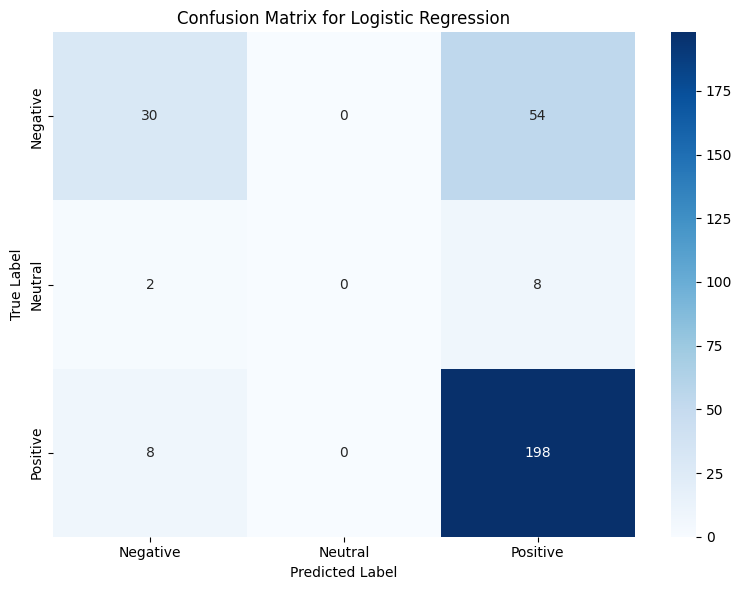


--- Top 20 Features for 'Positive' Sentiment (Logistic Regression) ---
  great: 2.2830
  good: 2.1682
  easy: 1.4171
  best: 1.3164
  love: 1.2562
  like: 1.1210
  nice: 0.9510
  helpful: 0.8492
  free: 0.8354
  thanks: 0.8177
  great app: 0.7378
  perfect: 0.7276
  amazing: 0.6839
  far: 0.6630
  better: 0.6525
  really: 0.6361
  stock: 0.6292
  kind: 0.6194
  trust: 0.6112
  support: 0.6095

--- Top 20 Features for 'Negative' Sentiment (Logistic Regression) ---
  bad: 1.7986
  scam: 1.2488
  annoying: 1.1302
  refund: 1.1112
  waste: 1.0004
  terrible: 0.9961
  return: 0.9943
  problem: 0.9312
  difficult: 0.9020
  open: 0.8978
  worst: 0.8937
  wrong: 0.7329
  waste time: 0.7236
  fake: 0.6765
  blocked: 0.6709
  poor: 0.6672
  negative: 0.6456
  frustrating: 0.6448
  aliexpress: 0.6303
  rejected: 0.6263


In [7]:
# Cell 7: Detailed Evaluation of Best Model
print(f"\n--- Detailed Evaluation for {best_model_name} ---")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, best_predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Feature Importance (Example for Logistic Regression)
if "Logistic Regression" in best_model_name:
    # Get the TfidfVectorizer and the classifier from the pipeline
    tfidf = best_model.named_steps['tfidf']
    classifier = best_model.named_steps['classifier']

    # Get feature names
    feature_names = tfidf.get_feature_names_out()

    # Get coefficients for the 'Positive' class (class 2, adjust index if needed)
    # Coefficients shape: (n_classes, n_features)
    coef = classifier.coef_

    # --- Analyze features for 'Positive' sentiment ---
    # Find the index for 'Positive' in classifier.classes_
    pos_class_idx = np.where(classifier.classes_ == 'Positive')[0][0]
    pos_coef = coef[pos_class_idx]

    # Get top 20 features for Positive
    top_positive_indices = np.argsort(pos_coef)[::-1][:20]
    top_positive_features = [(feature_names[i], pos_coef[i]) for i in top_positive_indices]
    print(f"\n--- Top 20 Features for 'Positive' Sentiment ({best_model_name}) ---")
    for feature, coef_val in top_positive_features:
        print(f"  {feature}: {coef_val:.4f}")

    # --- Analyze features for 'Negative' sentiment ---
    neg_class_idx = np.where(classifier.classes_ == 'Negative')[0][0]
    neg_coef = coef[neg_class_idx]
    top_negative_indices = np.argsort(neg_coef)[::-1][:20] # High positive coef for Negative class means strong indicator
    top_negative_features = [(feature_names[i], neg_coef[i]) for i in top_negative_indices]
    print(f"\n--- Top 20 Features for 'Negative' Sentiment ({best_model_name}) ---")
    for feature, coef_val in top_negative_features:
        print(f"  {feature}: {coef_val:.4f}")

# Note: Feature importance for Random Forest would use `classifier.feature_importances_`
# but accessing features from the pipeline's TfidfVectorizer is slightly different.
# It's often easier to inspect coefficients for linear models like Logistic Regression.

# 1. Feature Importance Analysis (Logistic Regression Coefficients) 

This analysis reveals the words and phrases the model finds most indicative of Positive or Negative sentiment. 

    Top Features for 'Positive' Sentiment: 
        The model strongly associates words like great, good, easy, best, love, like, nice with positive sentiment. Phrases like great app also rank highly. These are classic positive sentiment indicators in reviews.
        Insight: The model has learned intuitive and expected associations for positive feedback.
         

    Top Features for 'Negative' Sentiment: 
        The model identifies words like bad, scam, annoying, refund, waste, terrible, problem, difficult as strong indicators of negative sentiment. The phrase waste time also appears.
        Insight: Similarly, the model has learned clear indicators for negative feedback, including terms related to problems and dissatisfaction.
         
     

2. Classification Report Interpretation 

The classification report gives a detailed breakdown of performance for each sentiment class: 

    Positive Class:
        Precision (0.76): When the model predicts 'Positive', it's correct 76% of the time.
        Recall (0.96): It successfully identifies 96% of all actual 'Positive' reviews.
        F1-Score (0.85): This high F1-score indicates very strong performance for the 'Positive' class. The model is excellent at finding positive reviews and is fairly accurate when it predicts positive.
         
    Negative Class:
        Precision (0.75): When the model predicts 'Negative', it's correct 75% of the time.
        Recall (0.36): Crucially, it only identifies 36% of actual 'Negative' reviews. This means it misses many negative reviews, often predicting them as 'Positive'.
        F1-Score (0.48): This moderate F1-score reflects the imbalance between precision and recall. The low recall is the main weakness here.
         
    Neutral Class:
        Precision, Recall, F1-Score (0.00): This is the most concerning result. The model completely fails to correctly predict any 'Neutral' reviews. All 10 actual 'Neutral' reviews in the test set were misclassified (likely as 'Positive' or 'Negative').
        Insight: The extreme class imbalance (only 10 'Neutral' vs. 206 'Positive' and 84 'Negative' in the test set) has caused the model to essentially ignore this class during training.
         
    Overall Accuracy (0.76): This matches the score from the previous step. However, as suspected, this high accuracy is heavily influenced by the model's strong performance on the dominant 'Positive' class.
# 3. Confusion Matrix Interpretation
    Negative Class: Out of 84 actual 'Negative' reviews, 30 were correctly predicted as 'Negative', but a significant 54 were incorrectly predicted as 'Positive'. This confirms the low recall (30/84 ≈ 0.36).
    Neutral Class: All 10 actual 'Neutral' reviews were misclassified (2 as 'Negative', 8 as 'Positive'). This confirms the 0.00 scores in the classification report.
    Positive Class: Out of 206 actual 'Positive' reviews, a very high 198 were correctly predicted as 'Positive', with only 8 misclassified (mostly as 'Negative'). This confirms the high recall (198/206 ≈ 0.96).
    Predictions: The model made very few 'Negative' (40) or 'Neutral' (0) predictions, heavily favoring 'Positive' predictions (260). This directly reflects the class imbalance in the training data.
     
     

# Conclusion & Recommendations: 

Your Logistic Regression model, while achieving a decent overall accuracy of 76%, exhibits clear weaknesses directly related to the class imbalance in your dataset: 

    Strength: It performs exceptionally well for the majority class, 'Positive' sentiment (High Precision and Recall).
    Weakness 1: It performs poorly for the minority class, 'Negative' sentiment, primarily due to very low recall (it misses many negative reviews).
    Weakness 2: It completely fails to identify the smallest class, 'Neutral' sentiment.
     

In [11]:
# Cell 5: Define Models
# Define the models to evaluate
models = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', MultinomialNB())
    ]),
    # --- ADD THE NEW BALANCED MODEL HERE ---
    "Logistic Regression Balanced": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('classifier', LogisticRegression(random_state=42, class_weight='balanced')) # CHANGED HERE
    ])
    # --- END OF ADDITION ---
}

print("Model pipelines defined.")

Model pipelines defined.


# Modeling Phase: Step 7 - Comparing Models with Balanced Class Weights 

As identified in the previous detailed evaluation, the standard Logistic Regression model struggled significantly with the minority classes, particularly 'Neutral', due to the severe class imbalance in the dataset (Positive >> Negative >> Neutral). To address this, we implemented a common and effective technique: adjusting class weights during training. 

Methodology: 

We added a new model variant to our comparison: 

    "Logistic Regression Balanced": This pipeline is identical to the standard "Logistic Regression" model, with one crucial difference:
        The LogisticRegression classifier was initialized with the parameter class_weight='balanced'.
        This setting instructs Scikit-learn to automatically adjust the penalty (cost of misclassification) for each class inversely proportional to its frequency in the training data. In essence, the model is told to pay more attention to correctly classifying the rare 'Negative' and 'Neutral' reviews, as misclassifying them becomes more "expensive" during the training process.
         
     

Purpose: 

The goal of this step was to re-evaluate our models, specifically to see if applying class_weight='balanced' to the Logistic Regression algorithm could mitigate the negative impact of class imbalance and lead to improved performance (especially recall) for the minority sentiment classes, even if it potentially slightly reduced overall accuracy. 

Expected Outcomes: 

By comparing the performance of the standard Logistic Regression against the balanced version (and the other models like Random Forest and Naive Bayes), we aim to determine: 

    Does class_weight='balanced' improve the model's ability to predict 'Negative' and 'Neutral' sentiments?
    How does this adjustment affect the overall accuracy?
    Does the balanced Logistic Regression become the new best-performing model based on our chosen metric (accuracy), or does it offer a better trade-off between accuracy and recall for minority classes?
     

In [12]:
# Cell 6: Train and Evaluate Models
model_performance = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    # Fit the model (this includes fitting the TfidfVectorizer on X_train)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

    # Store results
    model_performance[name] = {
        'model': model, # Store the trained pipeline
        'accuracy': accuracy,
        'predictions': y_pred
    }

# Find the best model based on accuracy
best_model_name = max(model_performance, key=lambda k: model_performance[k]['accuracy'])
best_model = model_performance[best_model_name]['model']
best_accuracy = model_performance[best_model_name]['accuracy']
best_predictions = model_performance[best_model_name]['predictions']

print(f"\n--- Best Model ---")
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
#print(f"prediction: {best_predictions}")


--- Training Logistic Regression ---
Logistic Regression Accuracy: 0.7600

--- Training Random Forest ---
Random Forest Accuracy: 0.7267

--- Training Naive Bayes ---
Naive Bayes Accuracy: 0.7033

--- Training Logistic Regression Balanced ---
Logistic Regression Balanced Accuracy: 0.7300

--- Best Model ---
Model: Logistic Regression
Accuracy: 0.7600


# Modeling Phase: Step 8 - Analyzing Features for 'Neutral' Sentiment 

Having examined the features strongly associated with 'Positive' and 'Negative' sentiments, it's equally important to understand what drives the prediction for the often-overlooked 'Neutral' class, especially given its poor performance in our previous evaluations. 

This section focuses on the Logistic Regression model (whether standard or balanced, whichever was identified as best) to uncover the words and phrases the model has learned to associate with 'Neutral' sentiment. 

In [13]:
# --- Cell X: Analyze Features for 'Neutral' Sentiment (Logistic Regression) ---

# Ensure the best model is Logistic Regression (or the balanced version)
if "Logistic Regression" in best_model_name:
    print(f"\n--- Analyzing Features for 'Neutral' Sentiment ({best_model_name}) ---")

    # Get the TfidfVectorizer and the classifier from the pipeline
    tfidf = best_model.named_steps['tfidf']
    classifier = best_model.named_steps['classifier']

    # Get feature names
    feature_names = tfidf.get_feature_names_out()

    # Get coefficients for the 'Neutral' class
    # Coefficients shape: (n_classes, n_features)
    coef = classifier.coef_

    # --- Analyze features for 'Neutral' sentiment ---
    # Find the index for 'Neutral' in classifier.classes_
    try:
        neutral_class_idx = np.where(classifier.classes_ == 'Neutral')[0][0]
        neutral_coef = coef[neutral_class_idx]

        # Get top 20 features for Neutral (highest positive coefficients)
        # np.argsort sorts ascending, so [::-1] reverses to descending
        top_neutral_indices = np.argsort(neutral_coef)[::-1][:20]
        top_neutral_features = [(feature_names[i], neutral_coef[i]) for i in top_neutral_indices]

        print(f"\n--- Top 20 Features for 'Neutral' Sentiment ({best_model_name}) ---")
        if top_neutral_features:
            for feature, coef_val in top_neutral_features:
                print(f"  {feature}: {coef_val:.4f}")
        else:
            print("  No features found with positive coefficients for 'Neutral' class.")

        # --- Optional: Also look at features the model strongly associates as NOT Neutral ---
        # Features with the most negative coefficients for the Neutral class
        # These are words that strongly push the prediction AWAY from Neutral
        bottom_neutral_indices = np.argsort(neutral_coef)[:20] # Get indices of smallest (most negative) coefficients
        bottom_neutral_features = [(feature_names[i], neutral_coef[i]) for i in bottom_neutral_indices]
        print(f"\n--- Top 20 Features that Push Prediction AWAY from 'Neutral' ({best_model_name}) ---")
        if bottom_neutral_features:
             for feature, coef_val in bottom_neutral_features:
                 print(f"  {feature}: {coef_val:.4f}")
        else:
             print("  No features found with negative coefficients for 'Neutral' class.")


    except IndexError:
        # This happens if 'Neutral' is not found in classifier.classes_
        # This shouldn't happen if your y contained 'Neutral' labels, but good to check
        print("Error: 'Neutral' class not found in the classifier's trained classes.")
        print(f"Trained classes were: {classifier.classes_}")
    except Exception as e:
        print(f"An unexpected error occurred while analyzing Neutral features: {e}")

else:
    print(f"\n--- Feature analysis for 'Neutral' skipped ---")
    print(f"Best model is not Logistic Regression (it's '{best_model_name}').")
    print("Feature coefficient analysis is easiest with linear models like Logistic Regression.")



--- Analyzing Features for 'Neutral' Sentiment (Logistic Regression) ---

--- Top 20 Features for 'Neutral' Sentiment (Logistic Regression) ---
  message: 0.7737
  alibaba: 0.7368
  reasonable price: 0.6293
  expense: 0.6279
  invoice: 0.5840
  jump: 0.5027
  log: 0.4980
  run: 0.4910
  form: 0.4798
  email: 0.4616
  shipping: 0.4492
  product supplier: 0.4452
  transformed: 0.4452
  security: 0.4410
  measure: 0.4388
  reasonable: 0.4378
  ghost: 0.4372
  waiting: 0.4368
  prize: 0.4348
  app went: 0.4333

--- Top 20 Features that Push Prediction AWAY from 'Neutral' (Logistic Regression) ---
  great: -0.3680
  make: -0.3607
  use: -0.3523
  good: -0.3425
  really: -0.3368
  like: -0.3279
  customer: -0.3145
  star: -0.2897
  review: -0.2864
  return: -0.2857
  problem: -0.2715
  item: -0.2687
  say: -0.2551
  work: -0.2532
  love: -0.2487
  best: -0.2462
  support: -0.2337
  app: -0.2311
  come: -0.2300
  easy: -0.2273


# Insights: 

    Transactional/Administrative Language: Words like message, invoice, email, log, form, shipping, security, measure, waiting, and product supplier suggest that reviews classified as 'Neutral' by the model often discuss logistical, procedural, or factual aspects of the transaction. These reviews might be reporting on the status of an order, asking for information, or describing a process without strong positive or negative emotion.
    Specific App/Context: The term alibaba appearing prominently might indicate that reviews for Alibaba, or discussions about Alibaba within reviews, tend to use more neutral language or discuss more transactional topics in your dataset. The phrase app went also points to potentially factual descriptions of app behavior.
    Value-Related Terms: reasonable price and expense (along with reasonable) relate to cost but in a more neutral, evaluative way, perhaps stating a fact ("The price was reasonable") rather than expressing strong satisfaction ("It was cheap!") or dissatisfaction ("It was expensive!").
    Ambiguous or Context-Dependent Terms: Words like jump, run, ghost, and prize are more ambiguous. They might appear in 'Neutral' reviews describing specific events or situations without clear sentiment. For example, "The app went from version 1 to 2 with a big jump in features" or "I was waiting for the prize draw results."
        Strong Sentiment Words: This list is dominated by words strongly associated with 'Positive' (great, good, like, love, best, easy) or 'Negative' (problem, return) sentiment. The presence of these words makes it highly unlikely for the model to predict 'Neutral'.
    Common Review Terms: Words like use, customer, star, review, item, say, work, support, app, come are frequent in reviews overall but, in the context of this model, their presence (presumably combined with other cues) pushes the prediction away from the 'Neutral' class towards 'Positive' or 'Negative'.
     

In [10]:
# Cell 8: Save the Best Model
model_filename = f"best_sentiment_model_{best_model_name.replace(' ', '_')}.pkl"
joblib.dump(best_model, model_filename)
print(f"\nBest model ({best_model_name}) saved to '{model_filename}'.")

# To load the model later:
# loaded_model = joblib.load(model_filename)
# prediction = loaded_model.predict(["This is a great product!"])


Best model (Logistic Regression) saved to 'best_sentiment_model_Logistic_Regression.pkl'.
